Import package + model

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cobra
from cobra.io import read_sbml_model, write_sbml_model
from cobra.flux_analysis import flux_variability_analysis
from tqdm import tqdm

In [18]:
M_xanthus = read_sbml_model(
    "../M_xanthus_model_V2.sbml"
)  # import the Myxococcus xanthus model
M_xanthus

Name,myxo_model
Memory address,79d635cdc3e0
Number of metabolites,1280
Number of reactions,1367
Number of genes,1192
Number of groups,0
Objective expression,1.0*OF_BIOMASS - 1.0*OF_BIOMASS_reverse_80d2e
Compartments,"c, e"


In [19]:
E_coli = read_sbml_model("../E_coli_model.sbml")
E_coli

Name,iML1515
Memory address,79d62ed07380
Number of metabolites,1877
Number of reactions,2714
Number of genes,1516
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


**Adding Reactions**

In [20]:
Biomass_e = cobra.Metabolite(
    "Biomass_e", formula="BIOMASS", name="Biomass [e]", compartment="e"
)

M_xanthus.add_metabolites(Biomass_e)  # add M_xanthus.metabolites.Biomass_e

M_xanthus.add_boundary(
    M_xanthus.metabolites.get_by_id("Biomass_e"), type="exchange"
)  # add the exchange reaction for Biomass_e

Reaction identifier,EX_Biomass_e
Name,Biomass [e] exchange
Memory address,0x79d635cd1cd0
Stoichiometry,Biomass_e <=> Biomass [e] <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [21]:
Mreaction = cobra.Reaction("PR_BIOMASS")
Mreaction.name = "Predation Biomass"
Mreaction.subsystem = ""
Mreaction.lower_bound = 0.0  # This is the default
Mreaction.upper_bound = 1000.0  # This is the default

Biomass_e = M_xanthus.metabolites.Biomass_e

spmd_e = (
    M_xanthus.metabolites.spmd_e
)  # carbon source from exchange used in biomass reaction
pheme_e = M_xanthus.metabolites.pheme_e
val_L_e = M_xanthus.metabolites.val_L_e  # imported AA
ile_L_e = M_xanthus.metabolites.ile_L_e
leu_L_e = M_xanthus.metabolites.leu_L_e
lys_L_e = M_xanthus.metabolites.lys_L_e
his_L_e = M_xanthus.metabolites.his_L_e
gly_cys_L_e = M_xanthus.metabolites.gly_cys_L_e
cgly_e = M_xanthus.metabolites.cgly_e
pro_L_e = M_xanthus.metabolites.pro_L_e
alaala_e = M_xanthus.metabolites.alaala_e
glu_L_e = M_xanthus.metabolites.glu_L_e
met_L_e = M_xanthus.metabolites.met_L_e
thr_L_e = M_xanthus.metabolites.thr_L_e
# fru_e = M_xanthus.metabolites.fru_e  # import fructose
# man_e = M_xanthus.metabolites.man_e
gam_e = M_xanthus.metabolites.gam_e
# malt_e = M_xanthus.metabolites.malt_e
acald_e = M_xanthus.metabolites.acald_e  # import FA
acac_e = M_xanthus.metabolites.acac_e
# glyc3p_e = M_xanthus.metabolites.glyc3p_e
fum_e = M_xanthus.metabolites.fum_e  # should put directly the amino acids? asp and arg?
orn_e = M_xanthus.metabolites.orn_e
# succ_e = M_xanthus.metabolites.succ_e
# pi_e = M_xanthus.metabolites.pi_e  # from research
zn2_e = M_xanthus.metabolites.zn2_e  # Metals
mn2_e = M_xanthus.metabolites.mn2_e
mg2_e = M_xanthus.metabolites.mg2_e
k_e = M_xanthus.metabolites.k_e
cu2_e = M_xanthus.metabolites.cu2_e
cobalt2_e = M_xanthus.metabolites.cobalt2_e
cl_e = M_xanthus.metabolites.cl_e
ca2_e = M_xanthus.metabolites.ca2_e
so4_e = M_xanthus.metabolites.so4_e
# fe3_e = M_xanthus.metabolites.Fe3_e

# adocbl_e = M_xanthus.metabolites.adocbl_e # not used at all

Mreaction.add_metabolites(
    {
        Biomass_e: -1,
        spmd_e: 0.006744,
        pheme_e: 0.000223,
        val_L_e: 0.411184,
        ile_L_e: 0.282306,
        leu_L_e: 0.437778,
        lys_L_e: 0.333448,
        his_L_e: 0.092056,
        gly_cys_L_e: 0.024805,
        cgly_e: 0.1,  # TODO # never find in any iMAT
        pro_L_e: 0.214798, # never find in any iMAT
        alaala_e: 0.2495745,
        # fru_e: 0.1,
        # man_e: 0.1,
        gam_e: 1.2e-03,  # from: https://pmc.ncbi.nlm.nih.gov/articles/PMC2754216/#SM
        # malt_e: 1,
        glu_L_e: 0.255712, # sometime exported in quant iMAT
        met_L_e: 0.149336,
        thr_L_e: 0.246506, # never find in any iMAT
        fum_e: 1.2e-04,  # from: https://pmc.ncbi.nlm.nih.gov/articles/PMC2754216/#SM
        orn_e: 1.0e-05,  # from: https://pmc.ncbi.nlm.nih.gov/articles/PMC2754216/#SM
        # succ_e: 1,
        acald_e: 0.1,  # TODO
        acac_e: 0.1,  # TODO
        # glyc3p_e: 1,
        # pi_e: 0.1,
        zn2_e: 0.000324,
        mn2_e: 0.000658,
        mg2_e: 0.008253,
        k_e: 0.18569,
        cu2_e: 0.000674,
        cobalt2_e: 2.4e-05,
        cl_e: 0.004952,
        ca2_e: 0.004952,
        so4_e: 0.004126,
        # fe3_e: 0.007428, # sometime exported in quant iMAT - THEORY: Don't take from E.coli but in env to avoid E.coli to take
        # adocbl_e:1
    }
)  # add the metabolites to the reaction

Mreaction.gene_reaction_rule = ""  # define which gene allow the reaction

M_xanthus.add_reactions([Mreaction])  # add the PR_Biomass reaction

M_xanthus.reactions.PR_BIOMASS

Reaction identifier,PR_BIOMASS
Name,Predation Biomass
Memory address,0x79d636a607a0
Stoichiometry,Biomass_e --> 0.1 acac_e + 0.1 acald_e + 0.2495745 alaala_e + 0.004952 ca2_e + 0.1 cgly_e + 0.004952 cl_e + 2.4e-05 cobalt2_e + 0.000674 cu2_e + 0.00012 fum_e + 0.0012 gam_e + 0.255712 glu_L_e +... Biomass [e] --> 0.1 Acetoacetate [e] + 0.1 Acetaldehyde [e] + 0.2495745 Ala-Ala [e] + 0.004952 Ca2+ [e] + 0.1 Cys-Gly [e] + 0.004952 Cl- [e] + 2.4e-05 Co2+ [e] + 0.000674 Cu2+ [e] + 0.00012...
GPR,
Lower bound,0.0
Upper bound,1000.0


Change value

In [22]:
M_xanthus.reactions.EX_spmd_e.lower_bound = 0  # define the bound to 0 for metabolites in the reactions  # ? - not imported by E.coli / used for Biomass
M_xanthus.reactions.EX_pheme_e.lower_bound = (
    0  # amino acid - from Data / not imported by E.coli
)
M_xanthus.reactions.EX_val_L_e.lower_bound = 0  # amino acid - from Data
M_xanthus.reactions.EX_ile_L_e.lower_bound = 0  # amino acid - from Data
M_xanthus.reactions.EX_leu_L_e.lower_bound = 0  # amino acid - from Data
M_xanthus.reactions.EX_lys_L_e.lower_bound = 0  # amino acid
M_xanthus.reactions.EX_gly_cys_L_e.lower_bound = 0  # amino acid - from Data
M_xanthus.reactions.EX_cgly_e.lower_bound = 0  # amino acid - from Data
M_xanthus.reactions.EX_pro_L_e.lower_bound = 0  # amino acid - from Data
M_xanthus.reactions.EX_alaala_e.lower_bound = 0  # amino acid
M_xanthus.reactions.EX_glu_L_e.lower_bound = 0  # amino acid
M_xanthus.reactions.EX_met_L_e.lower_bound = 0  # amino acid - from Data
M_xanthus.reactions.EX_thr_L_e.lower_bound = 0  # amino acid
## M_xanthus.reactions.EX_fru_e.lower_bound = 0  # sugar - from data / article
## M_xanthus.reactions.EX_man_e.lower_bound = 0  # sugar - from data / article
M_xanthus.reactions.EX_gam_e.lower_bound = 0  # sugar - from data / article / iMAT
## M_xanthus.reactions.EX_malt_e.lower_bound = 0
M_xanthus.reactions.EX_acald_e.lower_bound = 0  # FA - from article
M_xanthus.reactions.EX_acac_e.lower_bound = 0  # FA - from article
## M_xanthus.reactions.EX_glyc3p_e.lower_bound = 0
M_xanthus.reactions.EX_fum_e.lower_bound = 0
M_xanthus.reactions.EX_orn_e.lower_bound = 0
# M_xanthus.reactions.EX_succ_e.lower_bound = 0
## M_xanthus.reactions.EX_pi_e.lower_bound = 0 # phosphate - from Data / in env
# M_xanthus.reactions.EX_zn2_e.lower_bound = 0 # Metals - from Data / in env
# M_xanthus.reactions.EX_mn2_e.lower_bound = 0 # Metals - from Data / in env
# M_xanthus.reactions.EX_mg2_e.lower_bound = 0 # Metals - from Data / in env
# M_xanthus.reactions.EX_k_e.lower_bound = 0 # Metals - from Data / in env
# M_xanthus.reactions.EX_cu2_e.lower_bound = 0 # Metals - from Data / in env
# M_xanthus.reactions.EX_cobalt2_e.lower_bound = 0 # Metals - from Data / in env
# M_xanthus.reactions.EX_cl_e.lower_bound = 0 # Metals - from Data / in env
# M_xanthus.reactions.EX_ca2_e.lower_bound = 0 # Metals - from Data / in env
# M_xanthus.reactions.EX_so4_e.lower_bound = 0 # sulfate - not imported by E.coli / in env
## M_xanthus.reactions.EX_Fe3_e.lower_bound = 0 # Metals - from data ? in env
## M_xanthus.reactions.EX_adocbl_e.lower_bound = 0

In [23]:
M_xanthus.reactions.EX_glc_D_e.id = (
    "EX_glc__D_e"  # change the name to correspond to E_coli
)

**Metabolites**

Can choose dynamicly which metabolites there are in the environment

In [24]:
## Problem need to have right name (ex: here in M_xanthus Ammonium = nothing)


def dynamic_metabolite(model: cobra.core.model.Model, metabolites: dict):
    """Convert the classic metabolites name into reaction used by the model. \n
    :param Model model: The model you want to used. \n
    :param dict y: A dictionary of the metabolite and their quantities in environment. ex: {Biomass: 100}
    """
    # convert to metabolites id
    Metabolites_id = {}
    for i in model.metabolites:
        for j in metabolites:
            if j in i.name:  # check metabolites name
                Metabolites_id[i.id] = j  # save its id if have metabolites in name

    # convert to reaction id
    FBA1 = model.optimize()  # perform FBA
    reaction_id = {}

    for i in model.exchanges._dict:  # filter for only exchange reaction
        for j in Metabolites_id:
            if (
                j in model.reactions.get_by_id(i).reaction and i not in reaction_id
            ):  # check if metabolites in reaction and if not already added
                if FBA1[i] < 0:
                    reaction_id[i] = Metabolites_id[j]  # add the reaction id

    # # Filter only the importation
    # reaction_id = {}

    # for i in reaction_id_temp:
    #     for j in metabolites:
    #         if FBA1[i] < 0:  # check if flux is below 0 (importation)
    #             reaction_id[j] = i # save it with the quantities

    return reaction_id

**Dynamic environment**

All the function

In [25]:
def add_dynamic_bounds(
    model: cobra.core.model.Model, y: dict, dico: dict, biomass: float
):
    """Use external concentrations to change the bound changing the uptake flux of the limited metabolites. \n
    :param Model model: The model you want to add dynamic bounds. \n
    :param dict y: A list of the metabolite quantities in environment. \n
    :param dict dico: A dictionary of the reaction \n
    :param float biomass: Quantities of Biomass in the environment.
    """
    for i in dico:
        model.reactions.get_by_id(i).lower_bound = (
            -10 * y[dico[i]] / (5 + y[dico[i]])
        )  # change the max import value for the metabolites

    biomass_max_import = -10 * biomass / (5 + biomass)

    M_xanthus.reactions.EX_glc__D_e.bounds = [0, 0]
    M_xanthus.reactions.EX_Biomass_e.lower_bound = biomass_max_import


def update_export(model: cobra.core.model.Model, fluxes: list, export: dict) -> dict:
    """Updtate the metabolites quantities depending of the secreted metabolites fluxes. \n
    :param Model model: The model you want to add the secreted metabolites. \n
    :param list(float) fluxes: The list of the fluxes. \n
    :param dict export: A dictionary that store the exported reaction
    """
    for i in model.exchanges._dict:
        if fluxes[i] > 0:
            name = model.reactions.get_by_id(
                i
            ).reaction.split()  # get the metabolites id
            meta = model.metabolites.get_by_id(name[0]).name  # get the metabolites name
            split = meta.split()
            if len(split) > 2:  # if the name is in multiple 'word'
                temp = []
                for j in range(len(split) - 1):
                    temp.append(split[j])  # store multiple 'word' name
                mult = " ".join(temp)  # create a single word with the list
                if mult not in export.keys():  # if its not in the dict add it
                    export[mult] = fluxes[i]
                if mult in export.keys():  # if its in the dict update it
                    export[mult] = export[mult] + fluxes[i]
            else:
                if split[0] not in export.keys():  # if its not in the dict add it
                    export[split[0]] = fluxes[i]
                if split[0] in export.keys():  # if its in the dict update it
                    export[split[0]] = export[split[0]] + fluxes[i]
    return export


def update_metabolites(fluxes: list, y: dict, dico: dict, export: dict, biomass: int):
    """Updtate the metabolites quantities depending of the fluxes. \n
    :param list(float) fluxes: The list of the fluxes. \n
    :param dict y: A list of the metabolite quantities in environment. \n
    :param dict dico: A dictionary of the reaction \n
    :param dict export: A dictionary that store the exported reaction \n
    :param int biomass: Quantities of Biomass in the environment.
    """
    for i in dico:
        y[dico[i]] = (
            y[dico[i]] + fluxes[i] * biomass
        )  # calculate the number of metabolites
        if y[dico[i]] < 0:
            y[dico[i]] = (
                0  # if the value goes below zero set the number of metaboltie to zero
            )

    for i in export:
        if i in y:  # if the exported metabolites is in the environment
            y[i] += export[i]  # update it
        else:  # if its not
            y[i] = export[i]  # add it

    return y


def update_biomass(
    fluxes_E: list, biomass_E: list, fluxes_M: list, biomass_M: list, it: int
) -> tuple[list, list]:
    """Updtate the Biomass quantities depending of the fluxes. \n
    :param list(float) fluxes_prey: The list of the fluxes of the prey. \n
    :param list(float) biomass_prey: A list of the biomass quantities of the prey. \n
    :param list(float) fluxes_pred: The list of the fluxes of the prey. \n
    :param list(float) biomass_pred: A list of the biomass quantities of the predator. \n
    :param int it: The iteration of the loop.
    """
    # update the biomass of the prey
    if (
        biomass_E[it - 1]
        + fluxes_E["BIOMASS_Ec_iML1515_core_75p37M"] * biomass_E[it - 1]
        + fluxes_M["EX_Biomass_e"] * biomass_M[it - 1]
        < 0
    ):  # if the biomass is negative
        biomass_E.append(0)  # the biomass is 0
    else:
        biomass_E.append(
            biomass_E[it - 1]
            + fluxes_E["BIOMASS_Ec_iML1515_core_75p37M"]
            * biomass_E[it - 1]  # add the biomass production of prey
            + fluxes_M["EX_Biomass_e"]
            * biomass_M[it - 1]  # remove the biomass consuption by predator
        )

    # update the biomass of the predator
    biomass_M.append(biomass_M[it - 1] + fluxes_M["OF_BIOMASS"] * biomass_M[it - 1])

    return biomass_E, biomass_M

"run" function

In [ ]:
FVA = True
t = 0
tf = 50
steps = 0.5
time_point = [0]
FVA_optimum = [1.0, 0.99, 0.95]
it = 1
y = {
    "Glucose": 100,
    "Ammonium": 100,
}  # give the metabolites and their quantities in the environment
export = {}  # store quantities of exported metabolites
biomass = 0  # quantity of Biomass in the environment (at start)
fluxes_E = []
fluxes_M = []
FVA_fluxes_E = {}
FVA_fluxes_M = {}
Biomass_E = [0.01]
Biomass_M = [0.01]
metabo_evo = []

reactions_list_E_coli = []  # get all reaction of E_coli model
for reaction in E_coli.reactions:
    reactions_list_E_coli.append(reaction.id)

reactions_list_M_xanthus = []
for reaction in M_xanthus.reactions:
    reactions_list_M_xanthus.append(reaction.id)


dico_e = dynamic_metabolite(E_coli, y)
dico_m = dynamic_metabolite(M_xanthus, y)

with tqdm(total=tf) as pbar:
    while t < tf:
        add_dynamic_bounds(
            E_coli, y, dico_e, Biomass_E[it - 1]
        )  ## For Escherichia coli
        FBA_1 = E_coli.optimize()  # perform flux balance analysis (FBA)
        fluxes_E_coli = FBA_1.fluxes.get(
            reactions_list_E_coli
        )  # store the fluxes of the FBA
        fluxes_E_coli *= 0.1  # multiply by Biomass Concentration to get flux
        fluxes_E.append(fluxes_E_coli)  # store all the fluxes
        if FVA:
            for i in FVA_optimum:
                FVA_1 = flux_variability_analysis(E_coli, fraction_of_optimum=i) # perform FVA for all differente fraction of optimum
                if i not in FVA_fluxes_E:
                    FVA_fluxes_E[i] = [FVA_1] # store the value
                else:
                    FVA_fluxes_E[i].append(FVA_1) # store the value
        export = update_export(
            E_coli, fluxes_E_coli, export
        )  # update the exported metabolites
        y = update_metabolites(
            fluxes_E_coli, y, dico_e, export, Biomass_E[it - 1]
        )  # update the environment

        add_dynamic_bounds(
            M_xanthus, y, dico_m, Biomass_E[it - 1]
        )  ## For Myxococcus xanthus
        FBA_2 = M_xanthus.optimize()
        fluxes_M_xanthus = FBA_2.fluxes.get(reactions_list_M_xanthus)
        fluxes_M_xanthus *= 0.1
        fluxes_M.append(fluxes_M_xanthus)
        if FVA:
            for i in FVA_optimum:
                FVA_2 = flux_variability_analysis(M_xanthus, fraction_of_optimum=i)
                if i not in FVA_fluxes_M:
                    FVA_fluxes_M[i] = [FVA_2]
                else:
                    FVA_fluxes_M[i].append(FVA_2)
        export = update_export(M_xanthus, fluxes_M_xanthus, export)
        y = update_metabolites(fluxes_M_xanthus, y, dico_m, export, Biomass_M[it - 1])

        Biomass_E, Biomass_M = update_biomass(
            fluxes_E_coli, Biomass_E, fluxes_M_xanthus, Biomass_M, it
        )

        time_point.append(time_point[it - 1] + steps)
        metabo_evo.append(y.copy())  # store the environment quantitites
        it += 1
        t += steps
        pbar.update(steps)

100%|██████████| 50.0/50 [1:14:47<00:00, 89.74s/it] 


**Visualisation**

Graphs

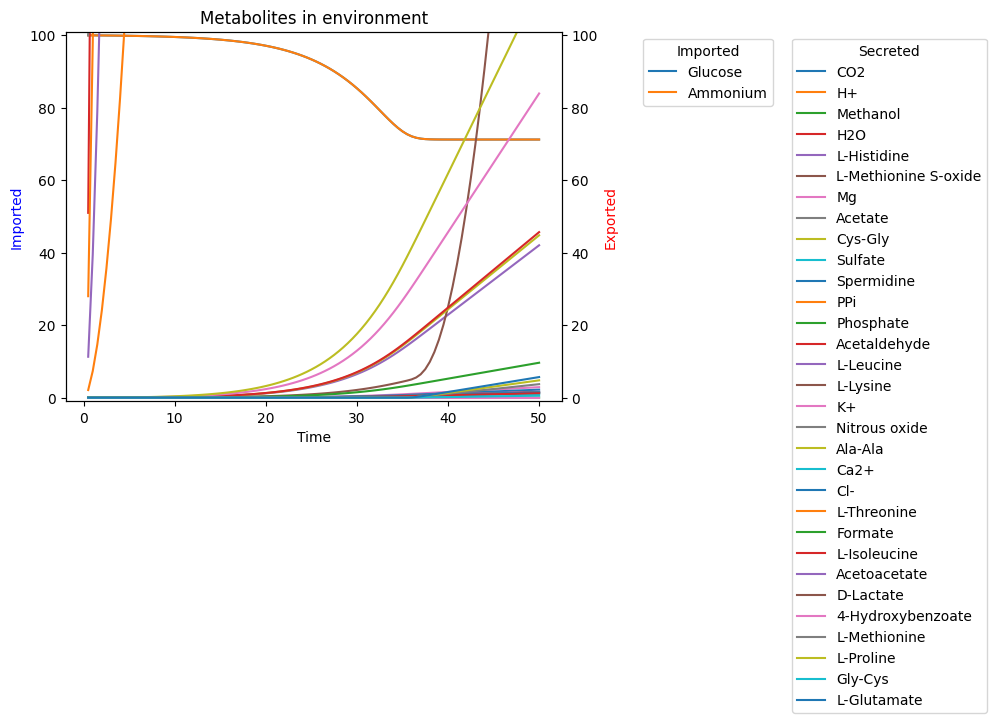

In [27]:
dico = {}
only_imported = False
only_secreted = False
for i in metabo_evo:  # i = dictionnary | j = name | i[j] = value
    for j in i:
        if j in dico:
            dico[j].append(i[j])
        else:
            dico[j] = [i[j]]

# Add zero at the start of the list if too short
for i in dico:
    if len(dico[i]) < len(time_point[1:]):
        while len(dico[i]) < len(time_point[1:]):
            dico[i].insert(0, 0)

ax = plt.subplot(111)
ax2 = plt.twinx(ax)
for i2 in dico:
    if only_imported:
        if dico[i2][0] > dico[i2][5]:
            ax.plot(time_point[1:], dico[i2], label=i2)
    elif only_secreted:
        if dico[i2][0] < dico[i2][5]:
            ax2.plot(time_point[1:], dico[i2], label=i2)
    else:
        if dico[i2][0] > dico[i2][5]:
            ax.plot(time_point[1:], dico[i2], label=i2)
        else:
            ax2.plot(time_point[1:], dico[i2], label=i2)
ax.set_ylabel("Imported", color="blue")
ax.set_xlabel("Time")

ax.set_title("Metabolites in environment")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left", title="Imported")
ax.set_ybound(-1, 101)

ax2.set_ylabel("Exported", color="red")
ax2.legend(bbox_to_anchor=(1.45, 1), loc="upper left", title="Secreted")
ax2.set_ybound(-1, 101)

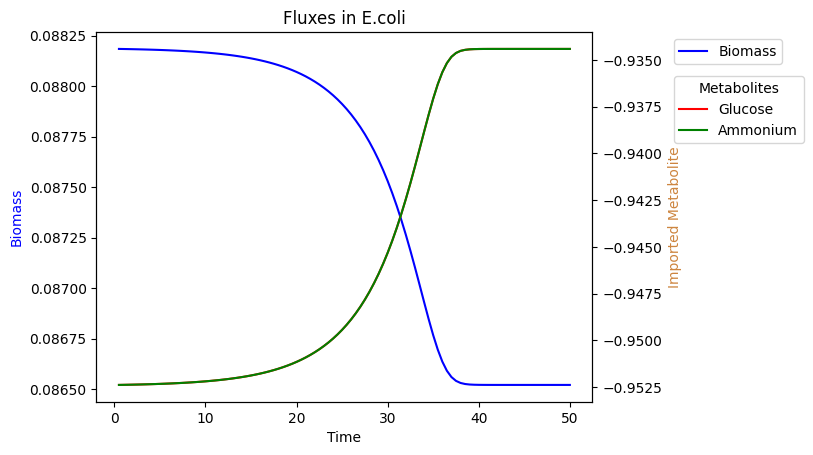

In [28]:
glucose = []
ammonium = []
biomass = []

for i in fluxes_E:
    glucose.append(i["EX_glc__D_e"])
    biomass.append(i["BIOMASS_Ec_iML1515_core_75p37M"])
    ammonium.append(i["EX_nh4_e"])

ax = plt.subplot(111)
ax.plot(time_point[1:], biomass, color="blue", label="Biomass")
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], glucose, color="red", label="Glucose")
ax2.plot(time_point[1:], ammonium, color="green", label="Ammonium")
ax.set_ylabel("Biomass", color="blue")
ax2.set_ylabel("Imported Metabolite", color="peru")
ax.set_xlabel("Time")

ax.set_title("Fluxes in E.coli")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left", title="Metabolites")

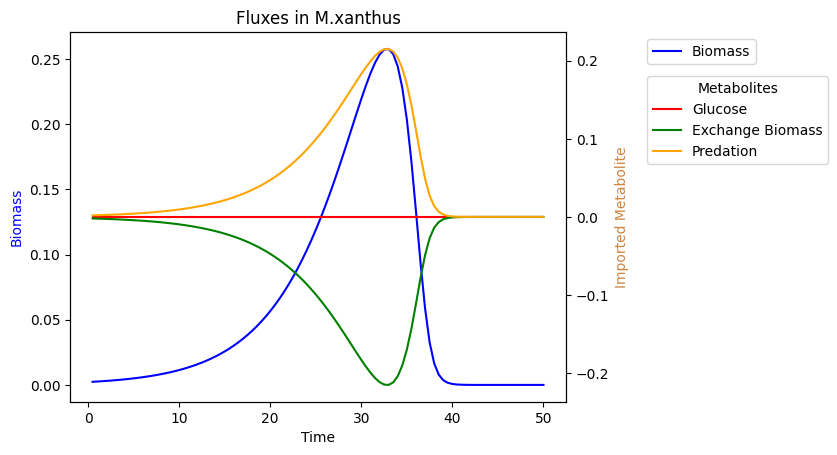

In [29]:
glucose = []
EX_bio = []
PR = []
biomass = []

for i in fluxes_M:
    glucose.append(i["EX_glc__D_e"])
    biomass.append(i["OF_BIOMASS"])
    PR.append(i["PR_BIOMASS"])
    EX_bio.append(i["EX_Biomass_e"])

ax = plt.subplot(111)
ax.plot(time_point[1:], biomass, color="blue", label="Biomass")
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], glucose, color="red", label="Glucose")
ax2.plot(time_point[1:], EX_bio, color="green", label="Exchange Biomass")
ax2.plot(time_point[1:], PR, color="orange", label="Predation")

ax.set_ylabel("Biomass", color="blue")
ax2.set_ylabel("Imported Metabolite", color="peru")
ax.set_xlabel("Time")

ax.set_title("Fluxes in M.xanthus")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left", title="Metabolites")

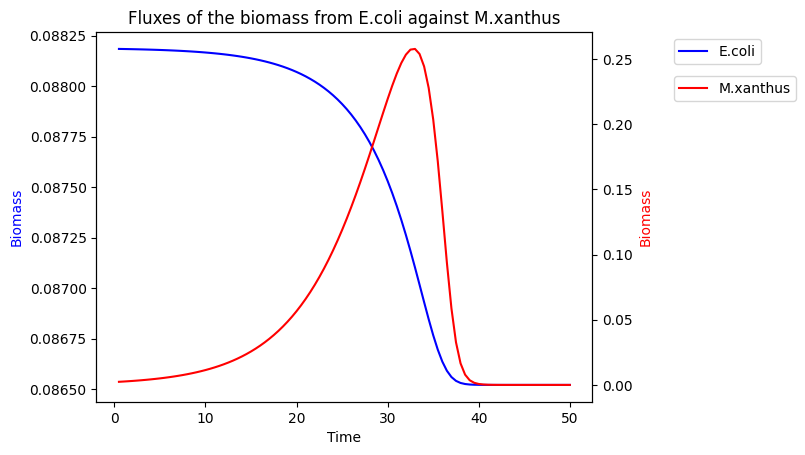

In [30]:
biomass_E = []
biomass_M = []

for i in fluxes_M:
    biomass_M.append(i["OF_BIOMASS"])  # taking the biomass flux
for j in fluxes_E:
    biomass_E.append(j["BIOMASS_Ec_iML1515_core_75p37M"])


ax = plt.subplot(111)
ax.plot(
    time_point[1:], biomass_E, color="blue", label="E.coli"
)  # plot the biomass flux of E_coli
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], biomass_M, color="red", label="M.xanthus")

ax.set_ylabel("Biomass", color="blue")  # set the name
ax2.set_ylabel("Biomass", color="red")
ax.set_xlabel("Time")

ax.set_title("Fluxes of the biomass from E.coli against M.xanthus")  # set the title
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")  # show the legend
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

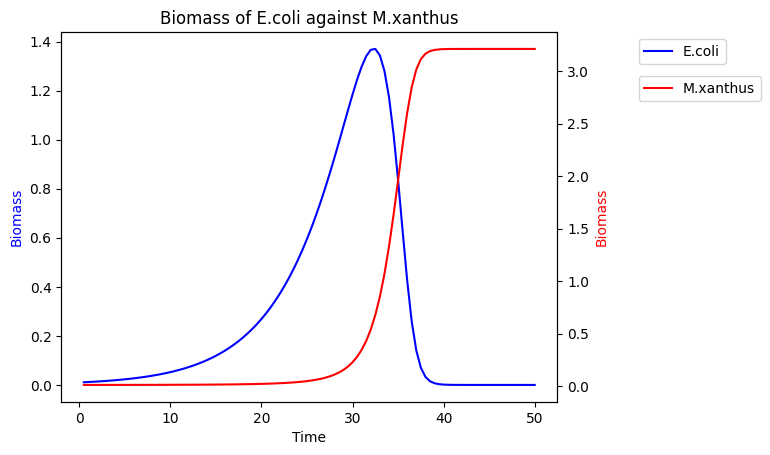

In [31]:
ax = plt.subplot(111)
ax.plot(
    time_point[1:], Biomass_E[1:], color="blue", label="E.coli"
)  # plot the biomass flux of E_coli
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], Biomass_M[1:], color="red", label="M.xanthus")

ax.set_ylabel("Biomass", color="blue")  # set the name
ax2.set_ylabel("Biomass", color="red")
ax.set_xlabel("Time")

ax.set_title("Biomass of E.coli against M.xanthus")  # set the title
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")  # show the legend
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

**FVA**

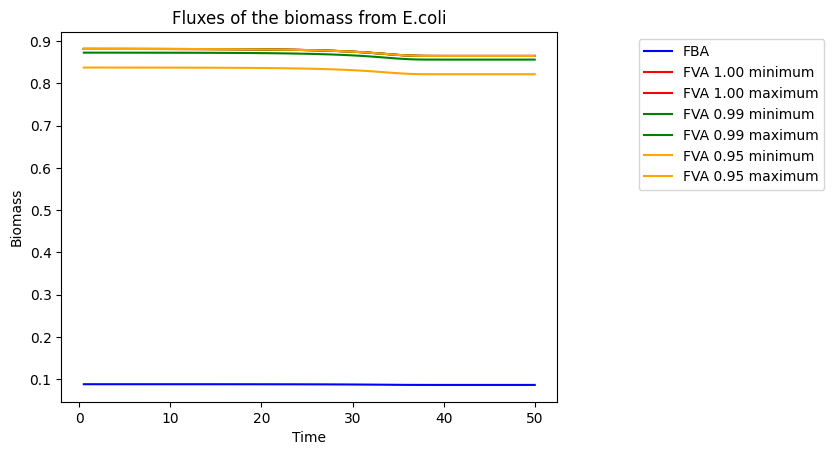

In [44]:
biomass_E = []
biomass_1_min = []
biomass_1_max = []
biomass_2_min = []
biomass_2_max = []
biomass_3_min = []
biomass_3_max = []


for i in FVA_fluxes_E[1.0]:
    biomass_1_min.append(i.loc[["BIOMASS_Ec_iML1515_core_75p37M"]].iloc[0]["maximum"])  # taking the biomass flux
    biomass_1_max.append(i.loc[["BIOMASS_Ec_iML1515_core_75p37M"]].iloc[0]["maximum"])  # taking the biomass flux
for i in FVA_fluxes_E[0.99]:
    biomass_2_min.append(i.loc[["BIOMASS_Ec_iML1515_core_75p37M"]].iloc[0]["minimum"])  # taking the biomass flux
    biomass_2_max.append(i.loc[["BIOMASS_Ec_iML1515_core_75p37M"]].iloc[0]["maximum"])  # taking the biomass flux
for i in FVA_fluxes_E[0.95]:
    biomass_3_min.append(i.loc[["BIOMASS_Ec_iML1515_core_75p37M"]].iloc[0]["minimum"])  # taking the biomass flux
    biomass_3_max.append(i.loc[["BIOMASS_Ec_iML1515_core_75p37M"]].iloc[0]["maximum"])  # taking the biomass flux
for j in fluxes_E:
    biomass_E.append(j["BIOMASS_Ec_iML1515_core_75p37M"])


ax = plt.subplot(111)
ax.plot(time_point[1:], biomass_E, color="blue", label="FBA")  # plot the biomass flux of E_coli
ax.plot(time_point[1:], biomass_1_min, color="red", label="FVA 1.00 minimum")
ax.plot(time_point[1:], biomass_1_max, color="red", label="FVA 1.00 maximum")
ax.plot(time_point[1:], biomass_2_min, color="green", label="FVA 0.99 minimum")
ax.plot(time_point[1:], biomass_2_max, color="green", label="FVA 0.99 maximum")
ax.plot(time_point[1:], biomass_3_min, color="orange", label="FVA 0.95 minimum")
ax.plot(time_point[1:], biomass_3_max, color="orange", label="FVA 0.95 maximum")

ax.set_ylabel("Biomass")  # set the name
ax.set_xlabel("Time")

ax.set_title("Fluxes of the biomass from E.coli")  # set the title
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")  # show the legend

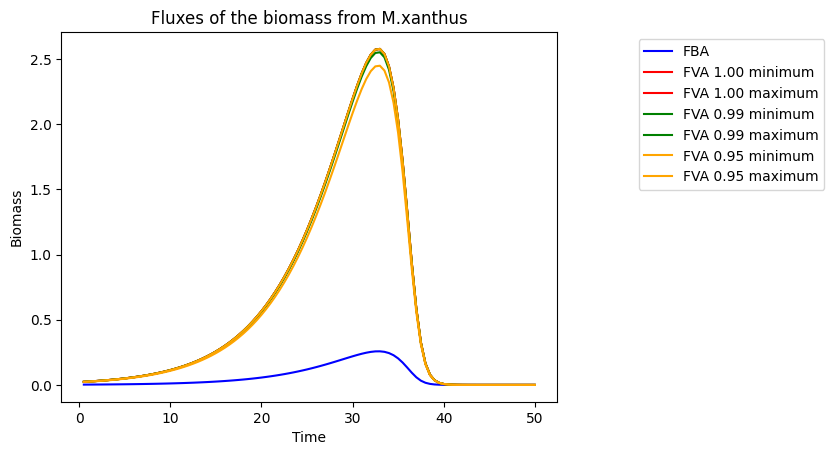

In [42]:
biomass_M = []
biomass_1_min = []
biomass_1_max = []
biomass_2_min = []
biomass_2_max = []
biomass_3_min = []
biomass_3_max = []


for i in FVA_fluxes_M[1.0]:
    biomass_1_min.append(i.loc[["OF_BIOMASS"]].iloc[0]["maximum"])  # taking the biomass flux
    biomass_1_max.append(i.loc[["OF_BIOMASS"]].iloc[0]["maximum"])  # taking the biomass flux
for i in FVA_fluxes_M[0.99]:
    biomass_2_min.append(i.loc[["OF_BIOMASS"]].iloc[0]["minimum"])  # taking the biomass flux
    biomass_2_max.append(i.loc[["OF_BIOMASS"]].iloc[0]["maximum"])  # taking the biomass flux
for i in FVA_fluxes_M[0.95]:
    biomass_3_min.append(i.loc[["OF_BIOMASS"]].iloc[0]["minimum"])  # taking the biomass flux
    biomass_3_max.append(i.loc[["OF_BIOMASS"]].iloc[0]["maximum"])  # taking the biomass flux
for j in fluxes_M:
    biomass_M.append(j["OF_BIOMASS"])


ax = plt.subplot(111)
ax.plot(time_point[1:], biomass_M, color="blue", label="FBA")  # plot the biomass flux of E_coli
ax.plot(time_point[1:], biomass_1_min, color="red", label="FVA 1.00 minimum")
ax.plot(time_point[1:], biomass_1_max, color="red", label="FVA 1.00 maximum")
ax.plot(time_point[1:], biomass_2_min, color="green", label="FVA 0.99 minimum")
ax.plot(time_point[1:], biomass_2_max, color="green", label="FVA 0.99 maximum")
ax.plot(time_point[1:], biomass_3_min, color="orange", label="FVA 0.95 minimum")
ax.plot(time_point[1:], biomass_3_max, color="orange", label="FVA 0.95 maximum")

ax.set_ylabel("Biomass")  # set the name
ax.set_xlabel("Time")

ax.set_title("Fluxes of the biomass from M.xanthus")  # set the title
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")  # show the legend